In [13]:
# ===============================
# Step 1: Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [14]:
# ===============================
# Step 2: Load Datasets
# ===============================
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())

Train shape: (2000, 21)
Test shape: (1000, 21)
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2       

/tmp/ipython-input-3719839178.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="price_range", data=train_df, palette="viridis")


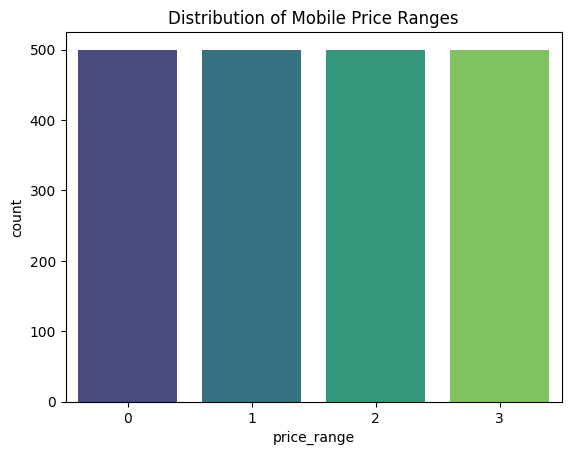

Missing values:
 battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


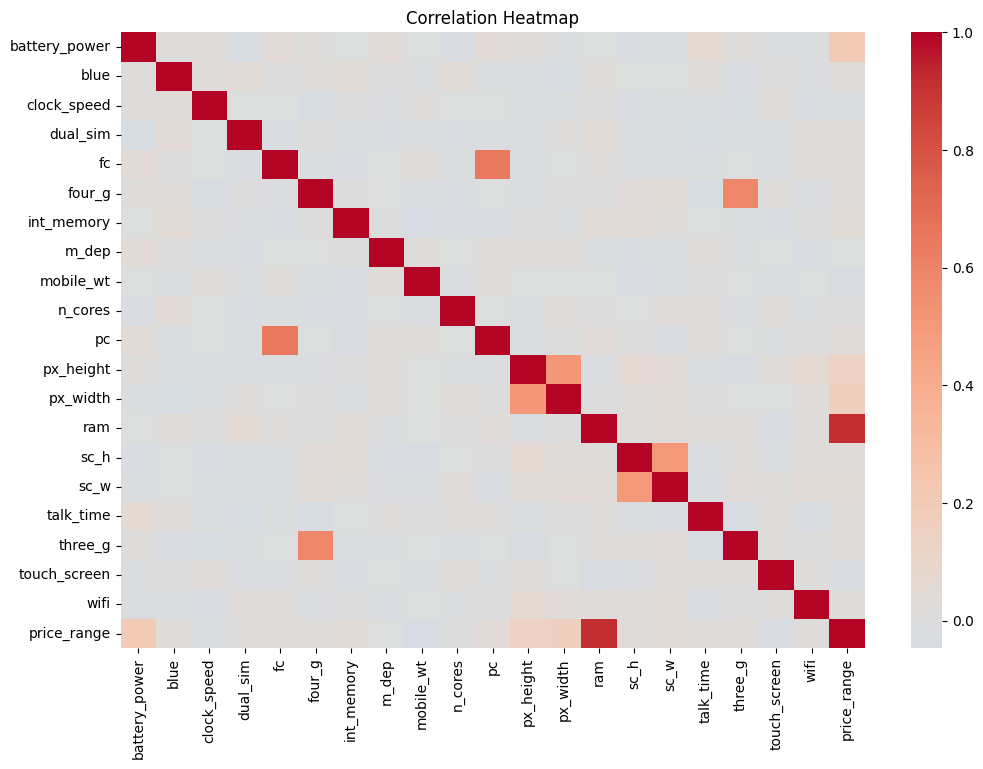

/tmp/ipython-input-3719839178.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_range", y="ram", data=train_df, palette="Set2")


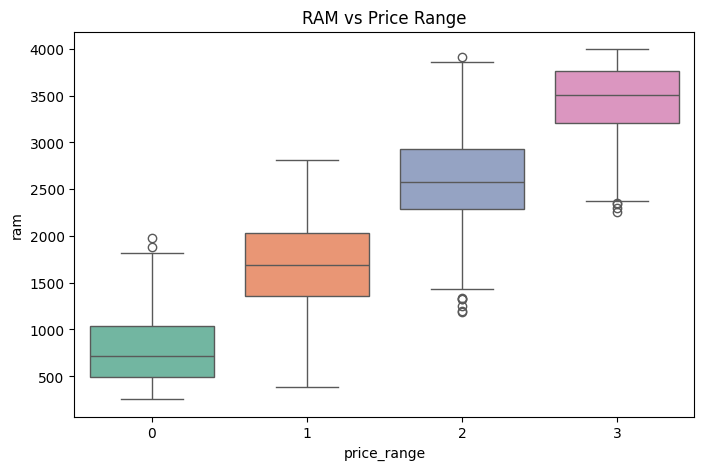

/tmp/ipython-input-3719839178.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_range", y="battery_power", data=train_df, palette="Set3")


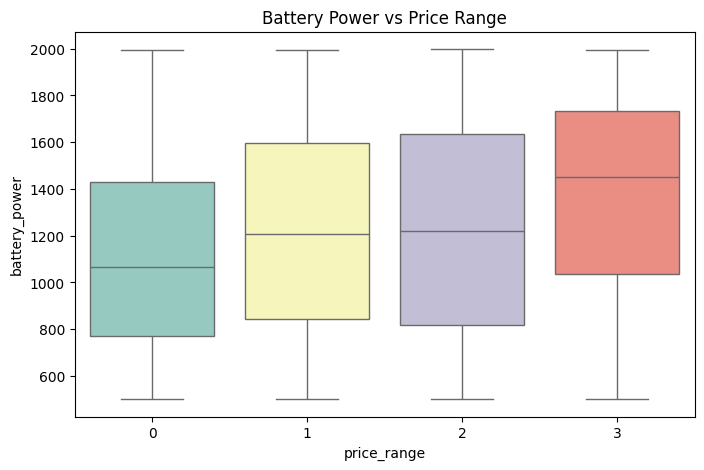

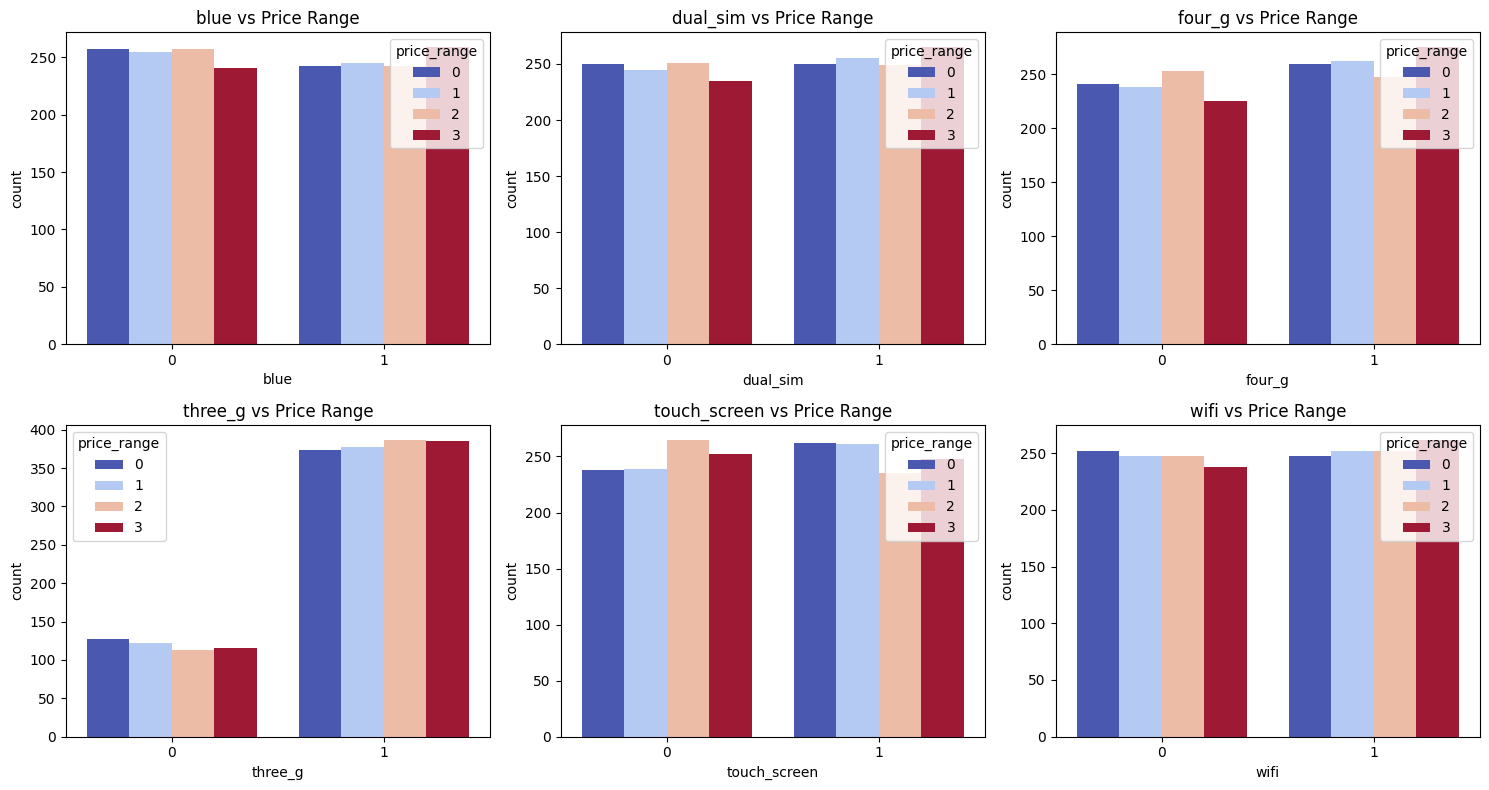

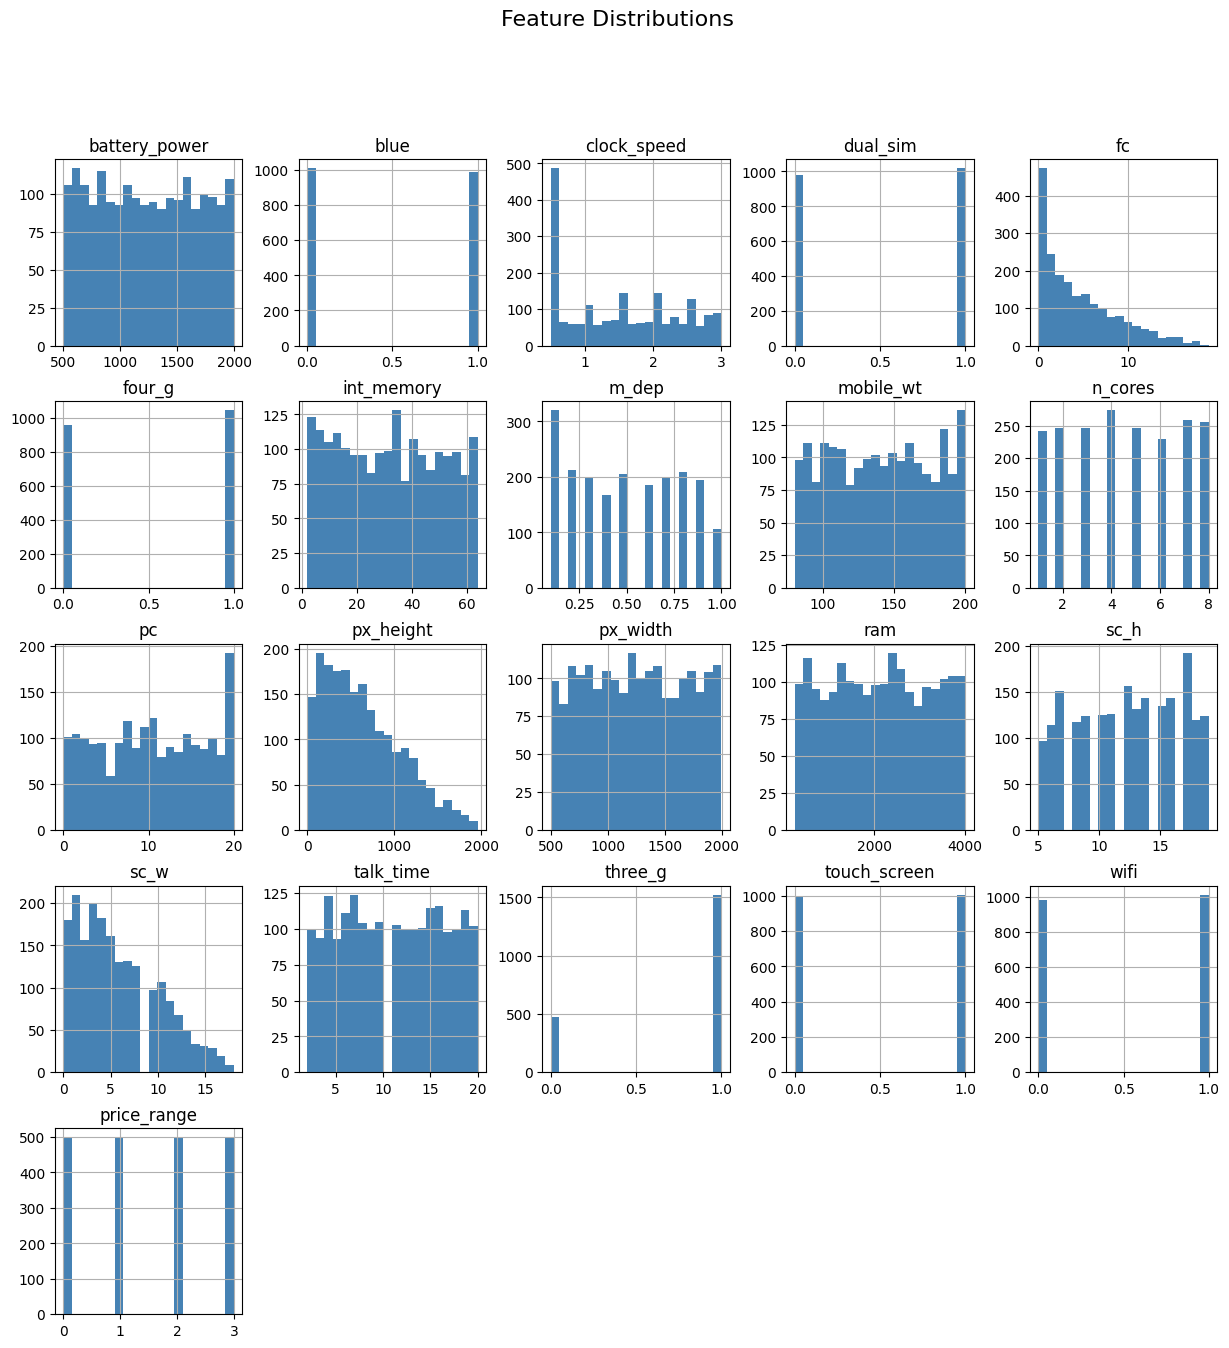

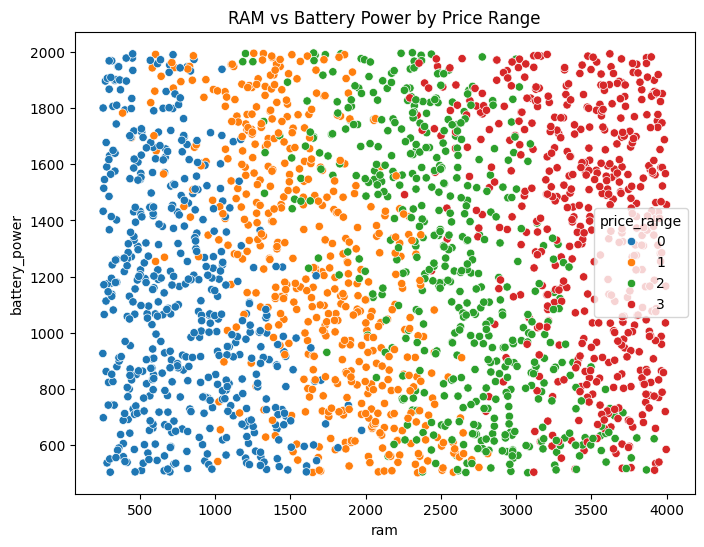

In [15]:
# ===============================
# Step 3: Exploratory Data Analysis (EDA)
# ===============================

# Target distribution
sns.countplot(x="price_range", data=train_df, palette="viridis")
plt.title("Distribution of Mobile Price Ranges")
plt.show()

# Missing values check
print("Missing values:\n", train_df.isnull().sum())

# Correlation heatmap
plt.figure(figsize=(12,8))
corr = train_df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

# Important numeric features vs target
plt.figure(figsize=(8,5))
sns.boxplot(x="price_range", y="ram", data=train_df, palette="Set2")
plt.title("RAM vs Price Range")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="price_range", y="battery_power", data=train_df, palette="Set3")
plt.title("Battery Power vs Price Range")
plt.show()

# Binary features
binary_features = ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()
for i, f in enumerate(binary_features):
    sns.countplot(x=f, hue="price_range", data=train_df, ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"{f} vs Price Range")
plt.tight_layout()
plt.show()

# Feature distributions
train_df.hist(bins=20, figsize=(15,15), color="steelblue")
plt.suptitle("Feature Distributions", size=16)
plt.show()

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x="ram", y="battery_power", hue="price_range", data=train_df, palette="tab10")
plt.title("RAM vs Battery Power by Price Range")
plt.show()


In [16]:
# ===============================
# Step 4: Preprocessing
# ===============================
X = train_df.drop("price_range", axis=1)
y = train_df["price_range"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_test_final = scaler.transform(test_df.drop("id", axis=1))  # Drop id before scaling

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
# ===============================
# Step 5: Baseline ML Models
# ===============================
print("=== Logistic Regression ===")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred_lr))

print("\n=== Random Forest ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred_rf))

=== Logistic Regression ===
Accuracy: 0.965

=== Random Forest ===
Accuracy: 0.88


In [18]:
# ===============================
# Step 6: Baseline ANN Classifier
# ===============================
model_base = Sequential([
    Dense(32, activation="relu", input_dim=X_train.shape[1]),
    Dense(4, activation="softmax")
])

model_base.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_base = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=0
)

loss_base, acc_base = model_base.evaluate(X_val, y_val, verbose=0)
print("Baseline ANN Validation Accuracy:", acc_base)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline ANN Validation Accuracy: 0.9300000071525574


In [19]:
# ===============================
# Step 7: Optimized ANN with Dropout
# ===============================
model_opt = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(4, activation="softmax")
])

model_opt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

history_opt = model_opt.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

loss_opt, acc_opt = model_opt.evaluate(X_val, y_val, verbose=0)
print("Optimized ANN Validation Accuracy:", acc_opt)

Optimized ANN Validation Accuracy: 0.9399999976158142


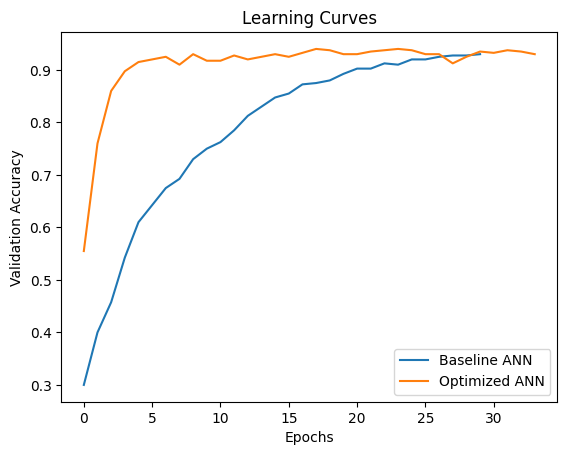

In [20]:
# ===============================
# Step 8: Learning Curves
# ===============================
plt.plot(history_base.history["val_accuracy"], label="Baseline ANN")
plt.plot(history_opt.history["val_accuracy"], label="Optimized ANN")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curves")
plt.legend()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       100
           1       0.92      0.92      0.92       100
           2       0.95      0.91      0.93       100
           3       0.95      0.97      0.96       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



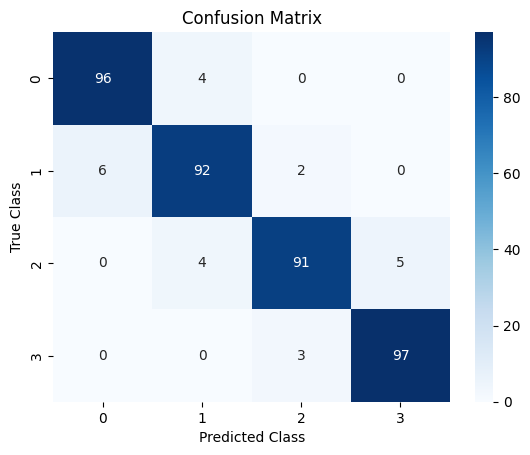

In [21]:
# ===============================
# Step 9: Evaluation
# ===============================
y_val_pred = model_opt.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

print("Classification Report:\n", classification_report(y_val, y_val_pred_labels))

cm = confusion_matrix(y_val, y_val_pred_labels)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=[0,1,2,3],
            yticklabels=[0,1,2,3])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# ===============================
# Step 10: Predictions on Test Data
# ===============================
test_predictions = model_opt.predict(X_test_final)
test_labels = np.argmax(test_predictions, axis=1)

submission = test_df.copy()
submission["price_range"] = test_labels
submission.to_csv("submission.csv", index=False)

print("Sample predictions:\n", submission.head())

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sample predictions:
    id  battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0   1           1043     1          1.8         1  14       0           5   
1   2            841     1          0.5         1   4       1          61   
2   3           1807     1          2.8         0   1       0          27   
3   4           1546     0          0.5         1  18       1          25   
4   5           1434     0          1.4         0  11       1          49   

   m_dep  mobile_wt  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0    0.1        193  ...        226      1412  3476    12     7          2   
1    0.8        191  ...        746       857  3895     6     0          7   
2    0.9        186  ...       1270      1366  2396    17    10         10   
3    0.5         96  ...        295      1752  3893    10     0          7   
4    0.5        108  ...        749       810  1773    15     8          7   

   thre

In [23]:
# ===============================
# Step 11: Prediction Probabilities
# ===============================
proba_df = pd.DataFrame(test_predictions, columns=["Class0", "Class1", "Class2", "Class3"])
proba_df["id"] = test_df["id"]
print("Prediction probabilities for first 5 test rows:\n", proba_df.head())

Prediction probabilities for first 5 test rows:
          Class0        Class1    Class2        Class3  id
0  1.013909e-20  8.756830e-07  0.135523  8.644764e-01   1
1  3.189264e-23  3.676118e-08  0.017072  9.829283e-01   2
2  2.227280e-15  1.545331e-04  0.912698  8.714768e-02   3
3  1.762677e-36  1.322543e-13  0.000050  9.999498e-01   4
4  1.463001e-03  9.948559e-01  0.003681  1.354451e-08   5
